In [1]:
import numpy as np
import torch
from torch import nn

import nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.coupling import AdditiveCouplingTransform, AffineCouplingTransform
from nflows.transforms.base import CompositeTransform
import matplotlib.pyplot as plt

from neulat.action import Phi4Action
from loss import ReparamKL
from neulat.models import Z2Nice, COUPLINGS

from tqdm import tqdm

import matplotlib.pyplot as plt 

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
T, L = 16, 8
lattice_shape = (T,L)

In [4]:
kappa = 0.3
lambd = 0.022
phi4_action = Phi4Action(kappa, lambd)

### Define flow in nflows

In [5]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker

In [6]:
make_checker_mask(lattice_shape, 0)

tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)

In [7]:
def make_mask(lattice_shape, parity):
    """
    Input: B x T, flattened 8*8
    """
    mask = make_checker_mask(lattice_shape, parity)
    return mask.flatten()

In [8]:
make_mask(lattice_shape, 0) + make_mask(lattice_shape, 1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)

In [9]:
class Net(nn.Module):
    def __init__(self, num_id, num_trf) -> None:
        super().__init__()
        mid_dim=1000
        nblocks=4

        self.net = nn.Sequential(
            nn.Linear(num_id, mid_dim, bias=False),
            nn.Tanh(),
            nn.Sequential(*[
                nn.Sequential(
                    nn.Linear(mid_dim, mid_dim, bias=False),
                    nn.Tanh(),
                ) for _ in range(nblocks)
            ]),
            nn.Linear(mid_dim, num_trf, bias=False)
        )
    
    def forward(self, x, ctx):
        return self.net(x)

In [10]:
class Z2NICE(AdditiveCouplingTransform):
    def __init__(self, mask, transform_net_create_fn, unconditional_transform=None, scale_activation=...):
        super().__init__(mask, transform_net_create_fn, unconditional_transform, scale_activation)

        self.scale = nn.Parameter(
            torch.zeros((1, torch.tensor(list(lattice_shape)).prod()//2)),
            requires_grad=True
        )

    def _scale_and_shift(self, transform_params):
        shift = transform_params
        scale = torch.exp(self.scale)
        return scale, shift

In [11]:
num_layers = 6
base_dist = StandardNormal(shape=[128]).to(device)

transforms = []
for i in range(num_layers):
    transforms.append(
        Z2NICE(
            make_mask(lattice_shape, i % 2), 
            Net
        ),
    )
transform = CompositeTransform(transforms)

flow_nflows = Flow(transform, base_dist)

In [12]:
coupling_factory = COUPLINGS["checkerfc"]
flow_neulat = Z2Nice(
    lat_shape=lattice_shape,
    coupling_factory=coupling_factory,
    ncouplings=6,
    nblocks=4,
    global_scaling=False
)

### Training

In [13]:
flow = flow_nflows
flow = flow.to(device)

In [14]:
kl_loss = ReparamKL(
    model=flow, 
    action=phi4_action, 
    lat_shape=lattice_shape,
    batch_size=8_000
)

In [15]:
def train_step(model, action, optimizer, batch_size):
    
    optimizer.zero_grad()

    loss, loss_summands, actions = kl_loss()
    
    loss.backward()
    optimizer.step()
    
    print("loss", loss.cpu().item())

    return loss.cpu().item()

In [22]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=8e-5, amsgrad=True)
losses = []
for epoch in range(1_001):
    print(epoch)
    loss = train_step(flow_nflows, phi4_action, optimizer, 8_000)
    losses.append(loss)

0
loss -133.91969299316406
1
loss -122.03638458251953
2
loss -130.64776611328125
3
loss -131.4786376953125
4
loss -130.06558227539062
5
loss -129.88177490234375
6
loss -130.65557861328125
7
loss -131.92823791503906
8
loss -132.67222595214844
9
loss -132.5657958984375
10
loss -132.52203369140625
11
loss -132.4610595703125
12
loss -132.45394897460938
13
loss -132.48843383789062
14
loss -132.74465942382812
15
loss -133.02627563476562
16
loss -133.2531280517578
17
loss -133.29229736328125
18
loss -133.28900146484375
19
loss -133.33738708496094
20
loss -133.3151092529297
21
loss -133.33294677734375
22
loss -133.30172729492188
23
loss -133.40957641601562
24
loss -133.51097106933594
25
loss -133.523193359375
26
loss -133.63694763183594
27
loss -133.6038818359375
28
loss -133.5949249267578
29
loss -133.61598205566406
30
loss -133.59788513183594
31
loss -133.63641357421875
32
loss -133.66653442382812
33
loss -133.6653594970703
34
loss -133.6793975830078
35
loss -133.739990234375
36
loss -133.77

KeyboardInterrupt: 

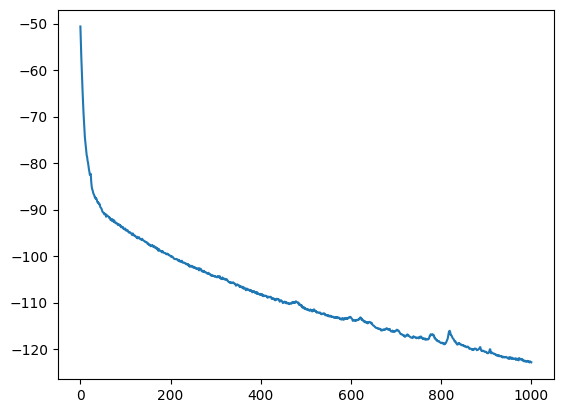

In [17]:
plt.plot(losses)